## Code Attribution

The code presented in this section, which generates dynamic spectra with varying pulse parameters, is the result of my work and has been adapted from Python notebooks authored by Joseph Kania. These notebooks utilized the WILL (Weighted Injector of Luminous Lighthouses) Python package.

### Code Author
- **Dirk Kuiper**

### Sources
The code has been adjusted and customized from the following sources:

- Joseph Kania's Python example notebooks, which provided the foundational code for generating dynamic spectra with pulses. These notebooks served as a valuable reference and inspiration for the implementation of the following code.

- The WILL (Weighted Injector of Luminous Lighthouses) Python package, which was used for several functions and utilities, enhancing the capabilities of the code.


## Show how we can inject a pulse into a GREENBURST filterbank.

In [1]:
import tempfile
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion import dedisperse
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject, detect
from your import Your
from simulate_frbs import *
from plotting import *

In [2]:
def show_dynamic(
    dynamic_spectra: np.ndarray, title: str = None, save: bool = False
) -> None:
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra - the dynamic spectra to plot

        title - Title of plot

        save - Save the plot as `title` + `.png`
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(20, 10))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std, aspect="auto")
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title.replace(" ", "_") + ".png", dpi=75, bbox_inches="tight")

## Creating a fresh filterbank file from scratch

Code adapted from: https://thepetabyteproject.github.io/your/0.6.6/ipynb/Writer/

I tried to make the header as consistent as possible with the Greenbank data from Zenodo, in case we will want to use it later to test with RFI etc.

In [55]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=512, num_time_samples=1024)

[1919.8828125 1919.6484375 1919.4140625 1919.1796875 1918.9453125
 1918.7109375 1918.4765625 1918.2421875 1918.0078125 1917.7734375
 1917.5390625 1917.3046875 1917.0703125 1916.8359375 1916.6015625
 1916.3671875 1916.1328125 1915.8984375 1915.6640625 1915.4296875
 1915.1953125 1914.9609375 1914.7265625 1914.4921875 1914.2578125
 1914.0234375 1913.7890625 1913.5546875 1913.3203125 1913.0859375
 1912.8515625 1912.6171875 1912.3828125 1912.1484375 1911.9140625
 1911.6796875 1911.4453125 1911.2109375 1910.9765625 1910.7421875
 1910.5078125 1910.2734375 1910.0390625 1909.8046875 1909.5703125
 1909.3359375 1909.1015625 1908.8671875 1908.6328125 1908.3984375
 1908.1640625 1907.9296875 1907.6953125 1907.4609375 1907.2265625
 1906.9921875 1906.7578125 1906.5234375 1906.2890625 1906.0546875
 1905.8203125 1905.5859375 1905.3515625 1905.1171875 1904.8828125
 1904.6484375 1904.4140625 1904.1796875 1903.9453125 1903.7109375
 1903.4765625 1903.2421875 1903.0078125 1902.7734375 1902.5390625
 1902.3046

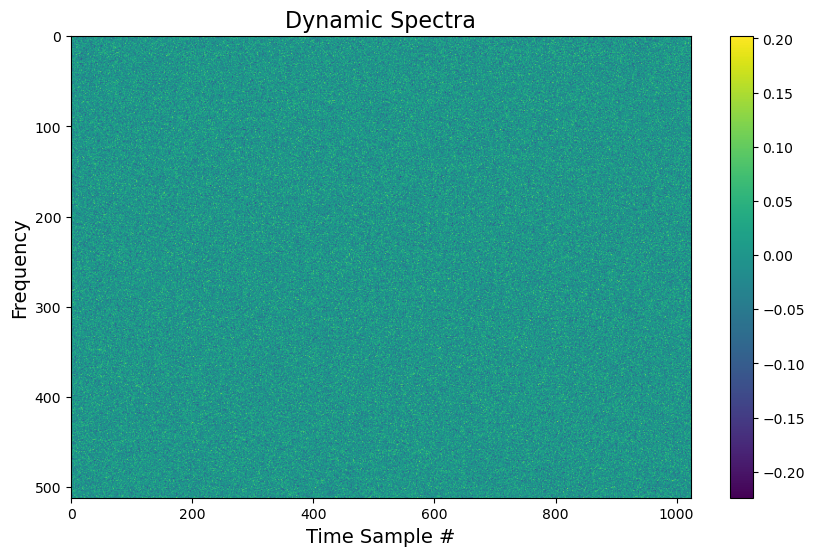

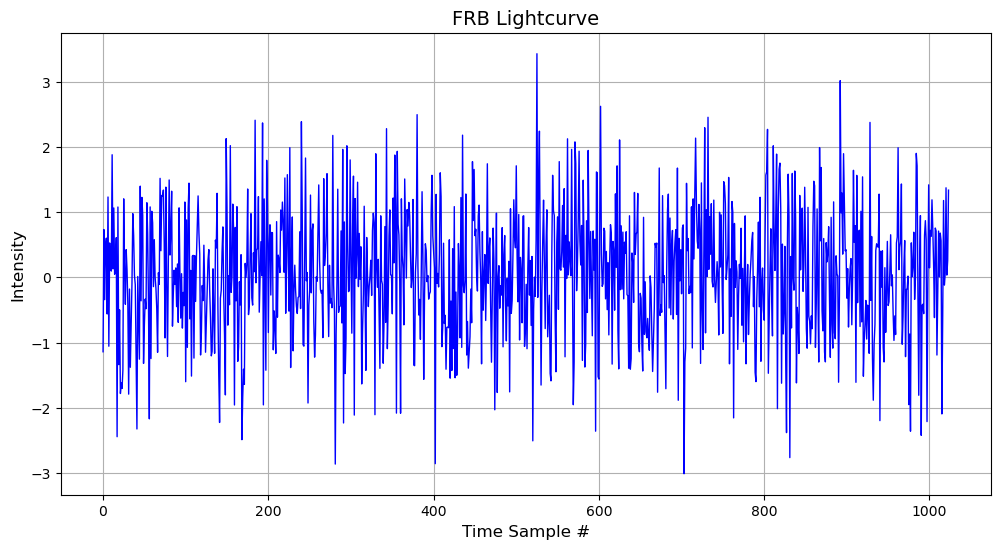

In [56]:
# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)

print(yr_obj.chan_freqs)

# Plot the dynamic spectra
plot_dynamic_spectra(dynamic_spectra)

# Sum the dynamic spectra along the frequency axis to create a lightcurve
lightcurve = np.sum(dynamic_spectra, axis=1)

# Plot the lightcurve using time sample numbers as the x-axis
plot_lightcurve(lightcurve=lightcurve, time_samples=np.arange(1024))


## Create a simple Pulse

(64, 512)


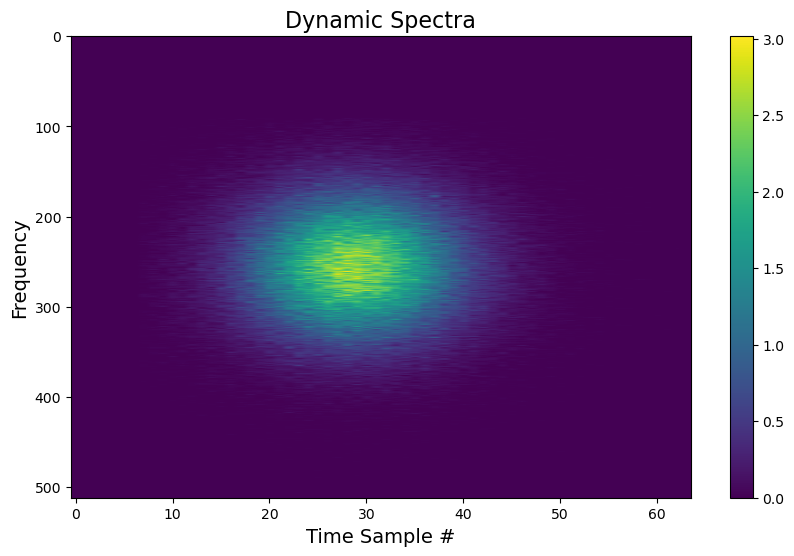

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Maximum value in the pulse: 3.0199999809265137


In [57]:
dm = 0
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=0.015/8,
    sigma_freq=100/8,
    center_freq=yr_obj.your_header.center_freq,
    dm=dm,
    tau=1,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=None,
)


# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5), dtype=np.float32)

print(np.shape(pulse))

pulse = (pulse * 0.02).astype(np.float32)

plot_dynamic_spectra(pulse)

print(pulse)
max_value = np.max(pulse)

print(f"Maximum value in the pulse: {max_value}")

# # Define the range
# min_value = 5
# max_value = 80

# # Define the exponent for the power law distribution
# exponent = -1.5  # Use a negative exponent

# # Generate a random number from a power law-like distribution
# scaling_factor = ((max_value**(exponent+1) - min_value**(exponent+1)) * np.random.random(1) + min_value**(exponent+1))**(1/(exponent+1))

# print(scaling_factor)

# pulse = (pulse * scaling_factor).astype(np.float32)

# print(pulse)



## Inject the Pulse

In [58]:
# Inject the pulse into the dynamic spectrum
dynamic_spectra_with_pulse = inject_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

## Show injected Pulse

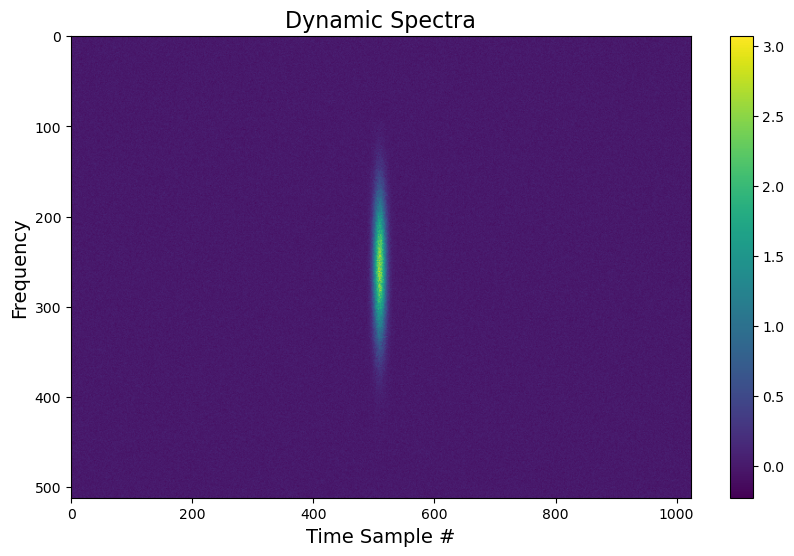

In [59]:
plot_dynamic_spectra(dynamic_spectra_with_pulse)

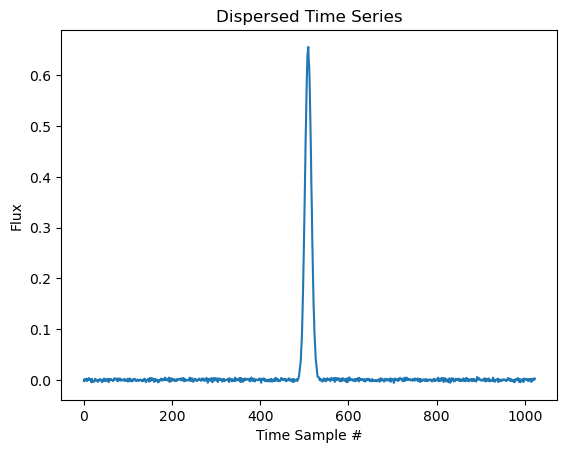

Time series Standard Deviation: 0.002
[[  9.75722194]
 [ 30.62547678]
 [ 58.80856688]
 [ 96.91760635]
 [141.96654606]
 [193.02325189]
 [245.86875423]
 [300.09496294]
 [339.52105034]
 [365.8194143 ]
 [378.95435915]
 [372.63017421]
 [351.70734466]
 [315.86429273]
 [266.33548992]
 [207.11545849]
 [146.72033343]
 [ 91.74108592]
 [ 40.89796753]]


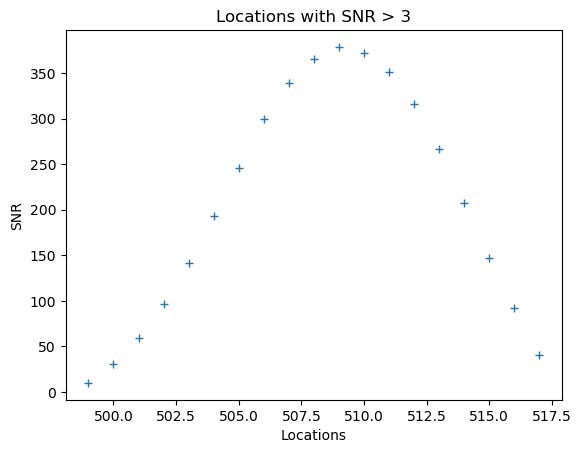

In [60]:
time_series = detect.dedisped_time_series(
    dynamic_spectra_with_pulse,
    dm=dm,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
)

plt.title("Dispersed Time Series")
plt.xlabel("Time Sample #")
plt.ylabel("Flux")
plt.plot(time_series)
plt.show()

sigma = 3
pulses = detect.detect_all_pulses(time_series, box_car_length=8, sigma=sigma)
print(f"Time series Standard Deviation: {pulses.std:.3f}")

print(pulses.snrs)

plt.title(f"Locations with SNR > {sigma}")
plt.plot(pulses.locations, pulses.snrs, "+")
plt.ylabel("SNR")
plt.xlabel("Locations")
plt.show()

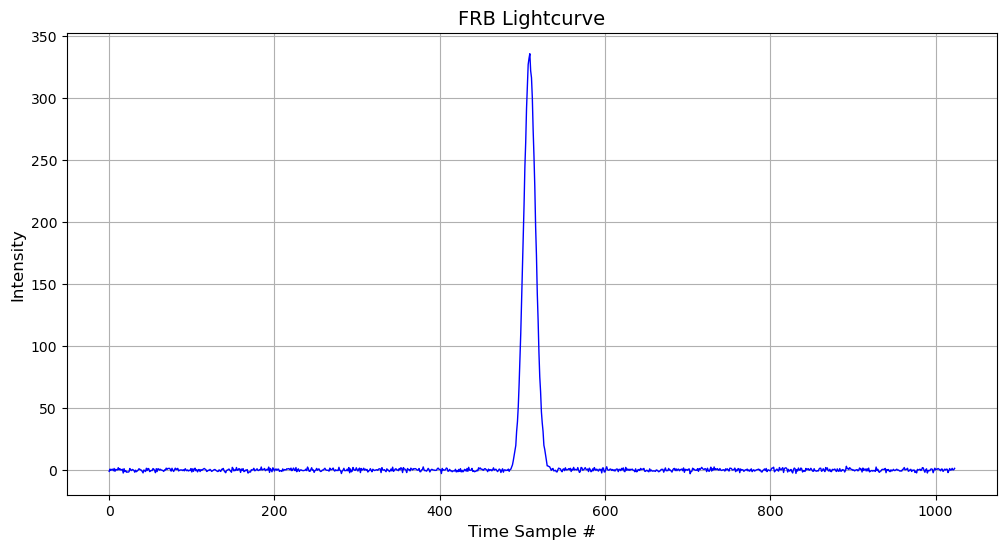

RMS of the noise: 0.9505736827850342
336.00378
0.9495824
353.84375
353.47473


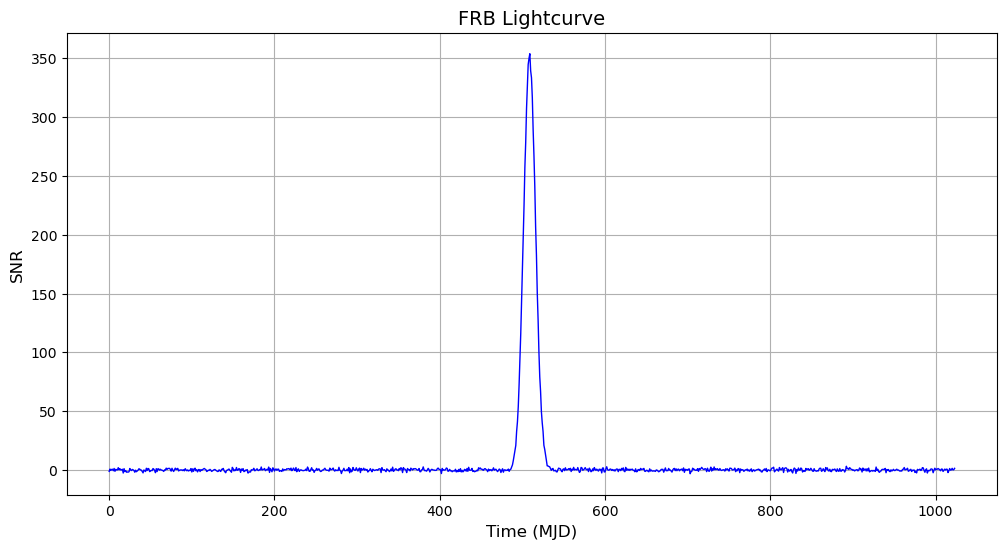

In [61]:
# Sum the frequencies along the frequency axis to get a 1D time series (lightcurve)
lightcurve = np.sum(dedisperse(
        dynamic_spectra_with_pulse,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    ), axis=1)

plot_lightcurve(time_samples=np.arange(1024), lightcurve=lightcurve)

squared_values = lightcurve[0:100] ** 2

# Calculate the mean of the squared values
mean_squared = np.mean(squared_values)

# Take the square root to get the RMS
rms = np.sqrt(mean_squared)

print(f"RMS of the noise: {rms}")

print(np.max(lightcurve))
print(np.std(lightcurve[0:100]))

print(np.max(lightcurve) / np.std(lightcurve[0:100]))

print(np.max(lightcurve)/rms)

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1024), lightcurve/np.std(lightcurve[0:100]), color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("SNR", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()


In [29]:
time_series = detect.dedisped_time_series(
    dynamic_spectra_w_pulse,
    dm=dm,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
)

plt.title("Dispersed Time Series")
plt.xlabel("Time Sample #")
plt.ylabel("Flux")
plt.plot(time_series)
plt.show()

sigma = 6
pulses = detect.detect_all_pulses(time_series, box_car_length=8, sigma=sigma)
print(f"Time series Standard Deviation: {pulses.std:.3f}")

print(pulses.snrs)

plt.title(f"Locations with SNR > {sigma}")
plt.plot(pulses.locations, pulses.snrs, "+")
plt.ylabel("SNR")
plt.xlabel("Locations")
plt.show()



NameError: name 'dynamic_spectra_w_pulse' is not defined

## Now for a pulse with a scattering tail

In [62]:
# Create a filterbank with noise, std is such that the lightcurve will have std 1
create_filterbank_with_noise("output_with_noise__2.fil", std_value=np.sqrt(1.0/512), mean_value=0.0, num_frequency_channels=512, num_time_samples=1024)

# Get the dynamic spectra from a filterbank file with 1024 time samples
dynamic_spectra, yr_obj = get_dynamic_spectra_from_filterbank(file_name='output_with_noise__2.fil', num_time_samples=1024)

(576, 512)


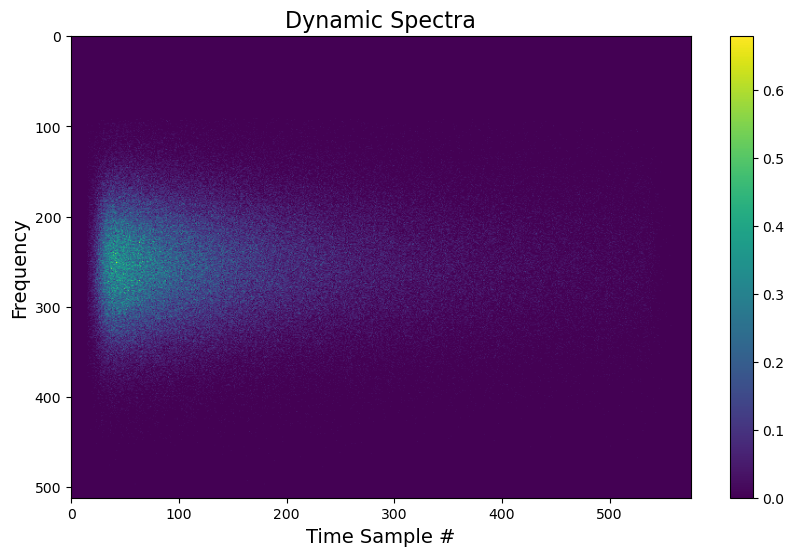

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Maximum value in the pulse: 0.6800000071525574


In [72]:
dm = 0
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=0.015/8,
    sigma_freq=100/8,
    center_freq=yr_obj.your_header.center_freq,
    dm=dm,
    tau=65,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=None,
)


# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5), dtype=np.float32)

print(np.shape(pulse))

pulse = (pulse * 0.02).astype(np.float32)

plot_dynamic_spectra(pulse)

print(pulse)
max_value = np.max(pulse)

print(f"Maximum value in the pulse: {max_value}")

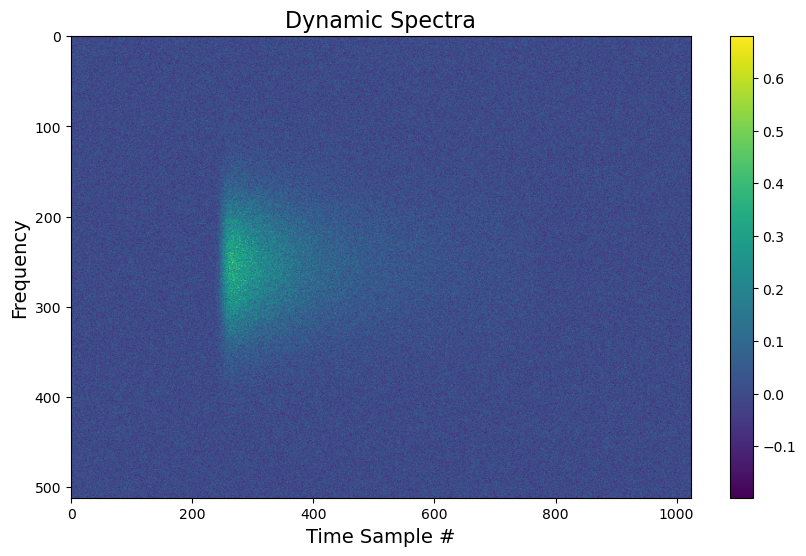

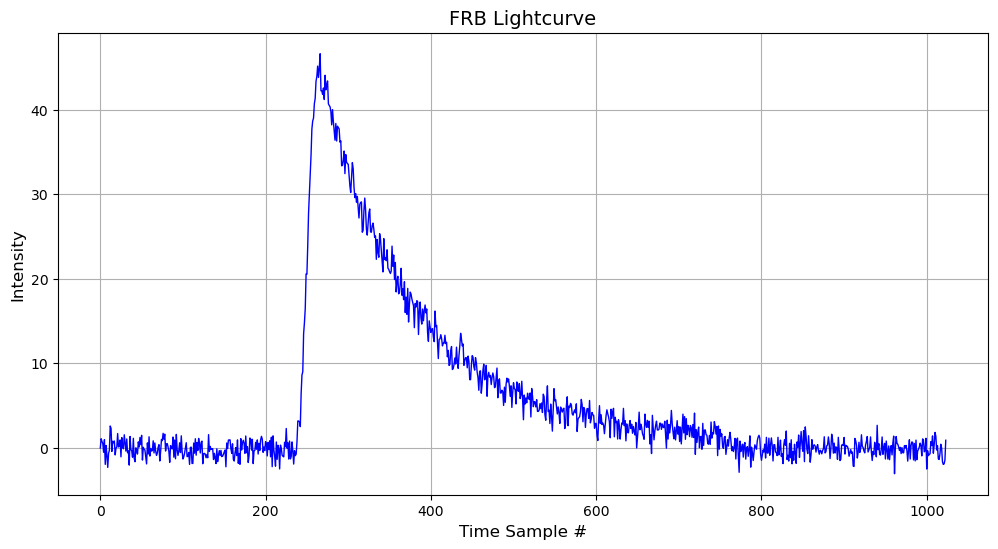

In [73]:
# Inject the pulse into the dynamic spectrum
dynamic_spectra_with_scattered_pulse = inject_pulse_into_dynamic_spectrum(dynamic_spectra, pulse)

plot_dynamic_spectra(dynamic_spectra_with_scattered_pulse)

lightcurve = np.sum(dynamic_spectra_with_scattered_pulse, axis=1)

plot_lightcurve(time_samples=np.arange(1024), lightcurve=lightcurve)

## Now for a pulse with complex time-frequency structure

In [48]:
dm_1 = 0
pulse_obj_complex = create.GaussPulse(
    relative_intensities=(1, 1),
    sigma_times=(0.015, 0.015),
    sigma_freqs=(100, 100),
    pulse_thetas=(0, 0),
    center_freqs=(yr_obj.your_header.center_freq, yr_obj.your_header.center_freq + 10),
    dm=dm_1,
    tau=1,
    offsets=(0, 0.03/8),  # all from start of window
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    spectral_index_alpha=0,
    nscint=0,
    phi=np.pi / 3,
    bandpass=None,
)
# pulse with 3e5 samples
pulse_complex = pulse_obj_complex.sample_pulse(nsamp=int(3e5), dtype=np.float32)

max_value = np.max(pulse_complex)

print(f"Maximum value in the pulse: {max_value}")



AssertionError: Probability array must be non-negative!

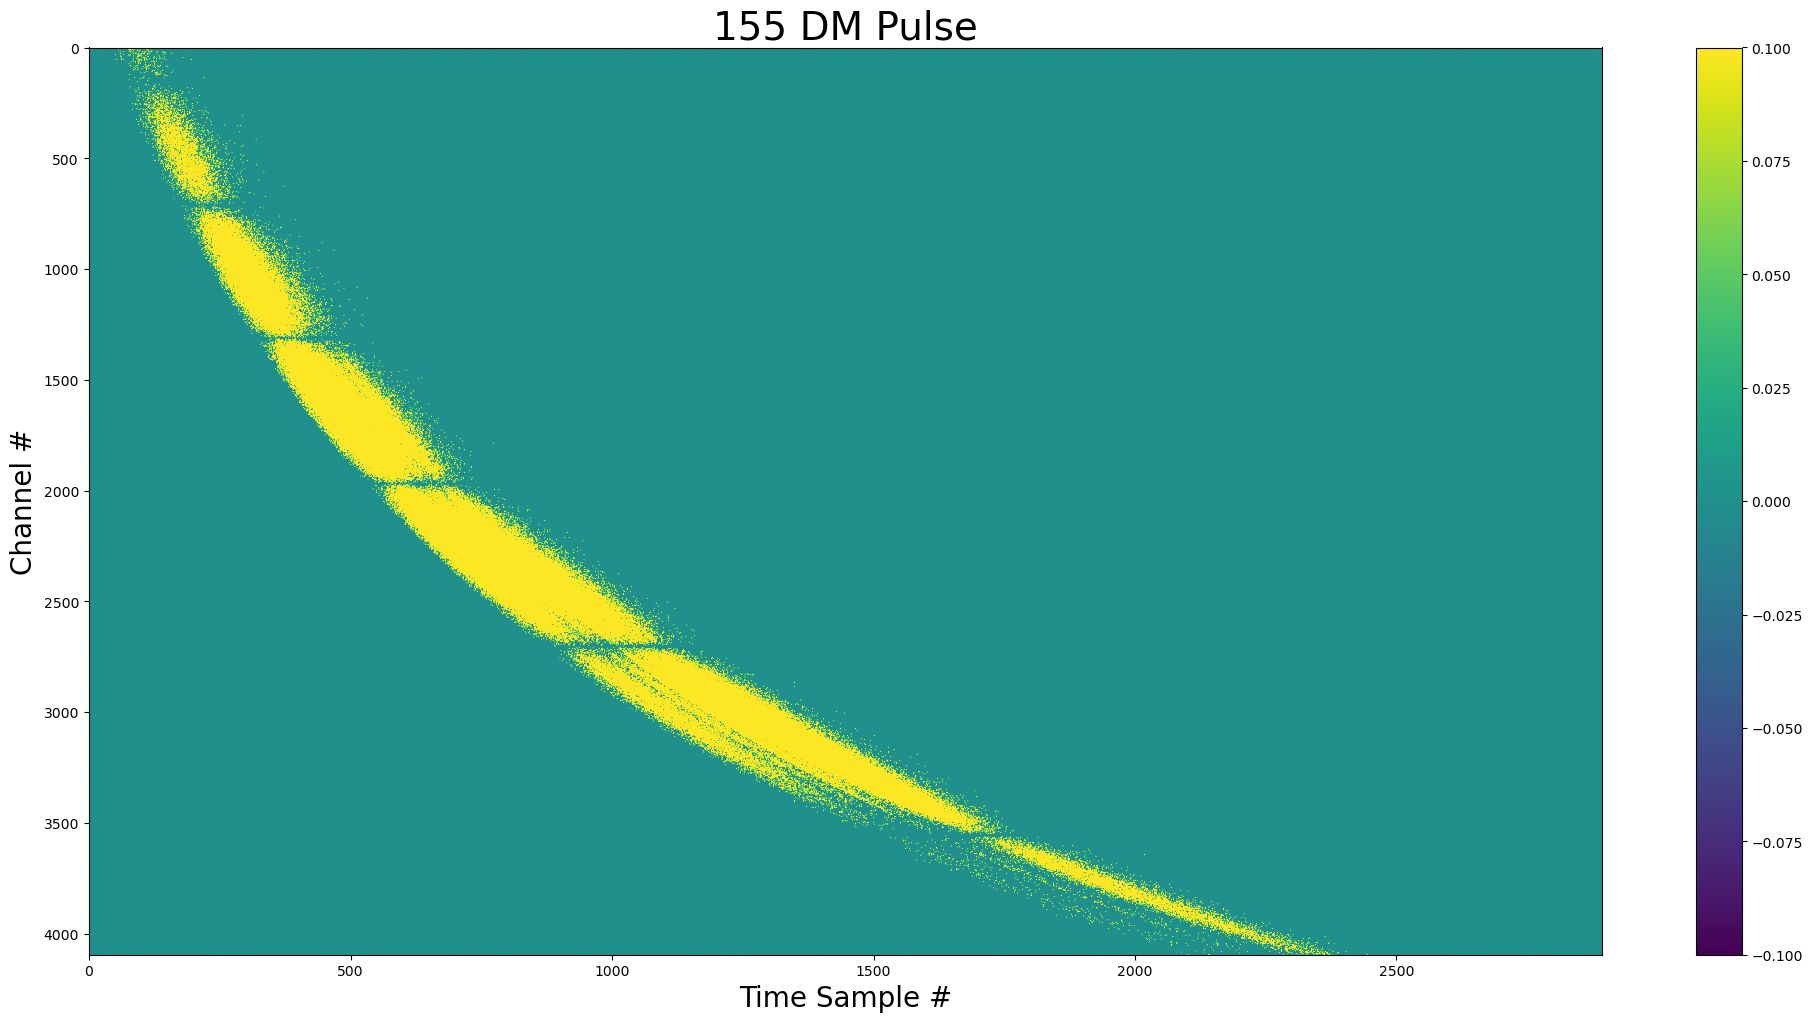

In [29]:
show_dynamic(pulse_complex, title=f"{dm_1} DM Pulse")

## Inject the pulse

In [30]:
dynamic_spectra_w_pulse_complex = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse_complex,
    start=yr_obj.your_header.nspectra // 2 ,
    gulp=yr_obj.your_header.nspectra,
)

ValueError: Invalid integer data type 'f'.

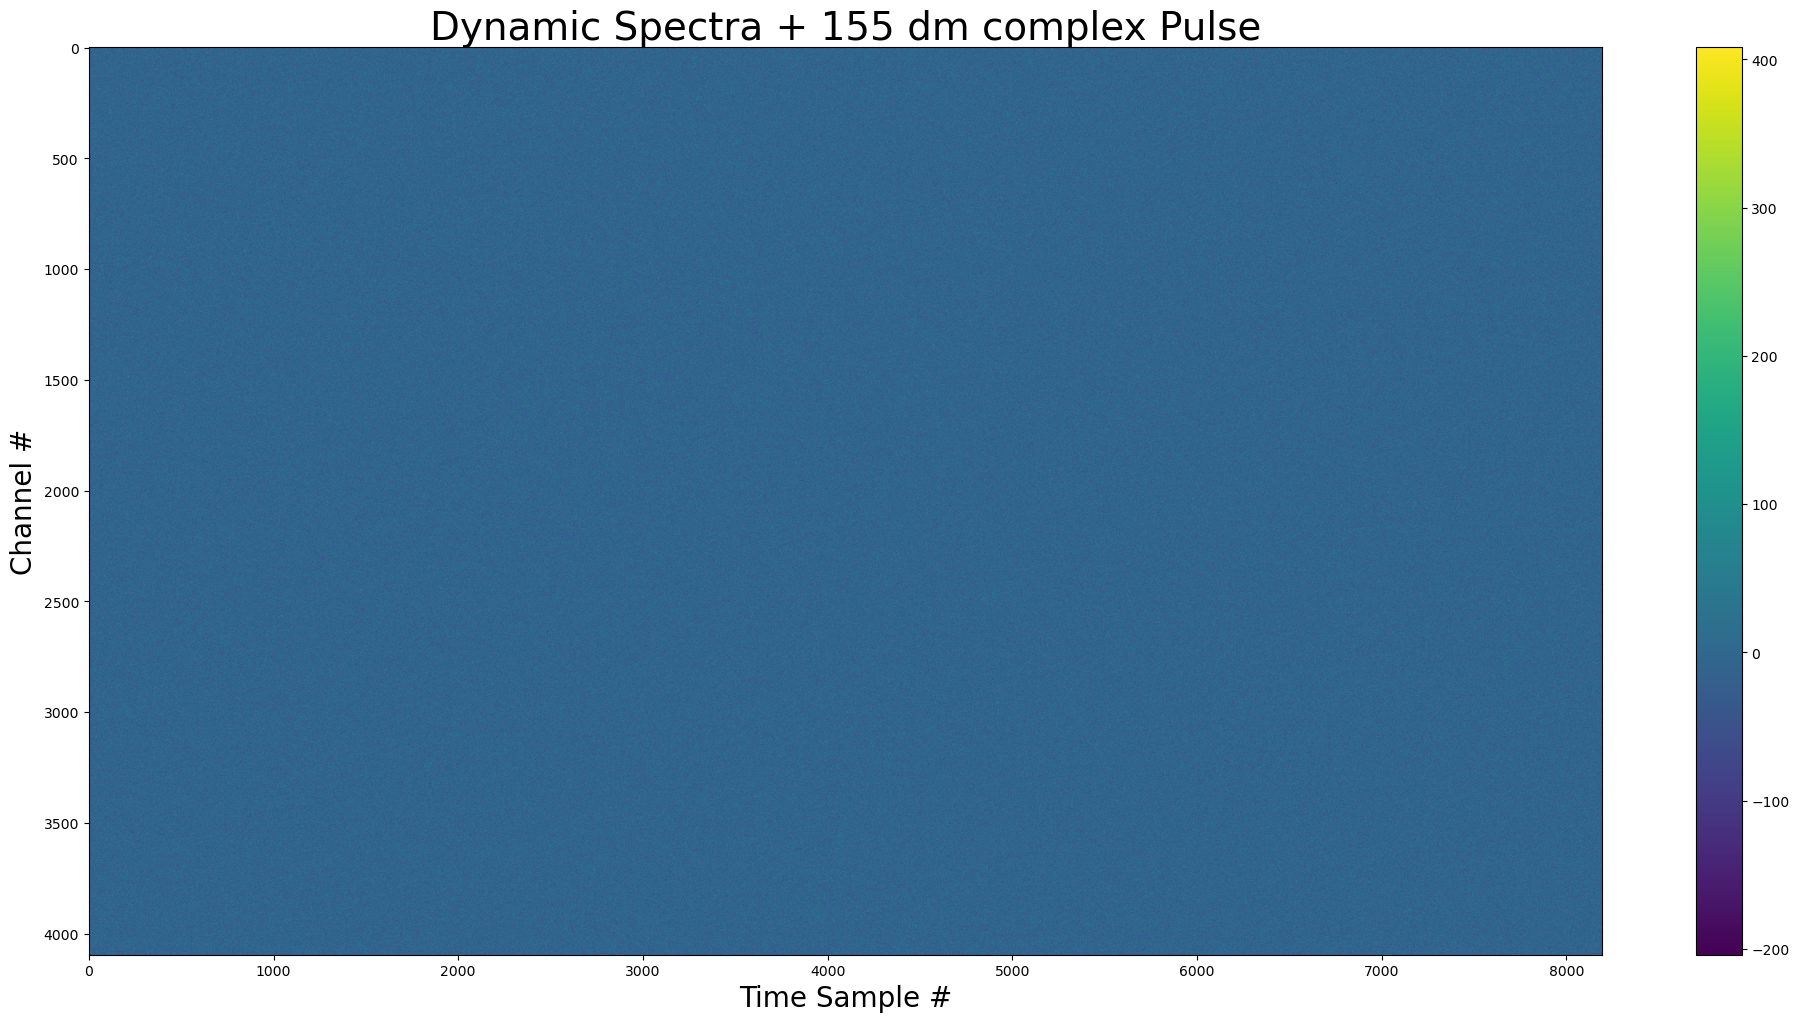

In [ ]:
show_dynamic(dynamic_spectra_w_pulse_complex, title=f"Dynamic Spectra + {dm_1} dm complex Pulse")

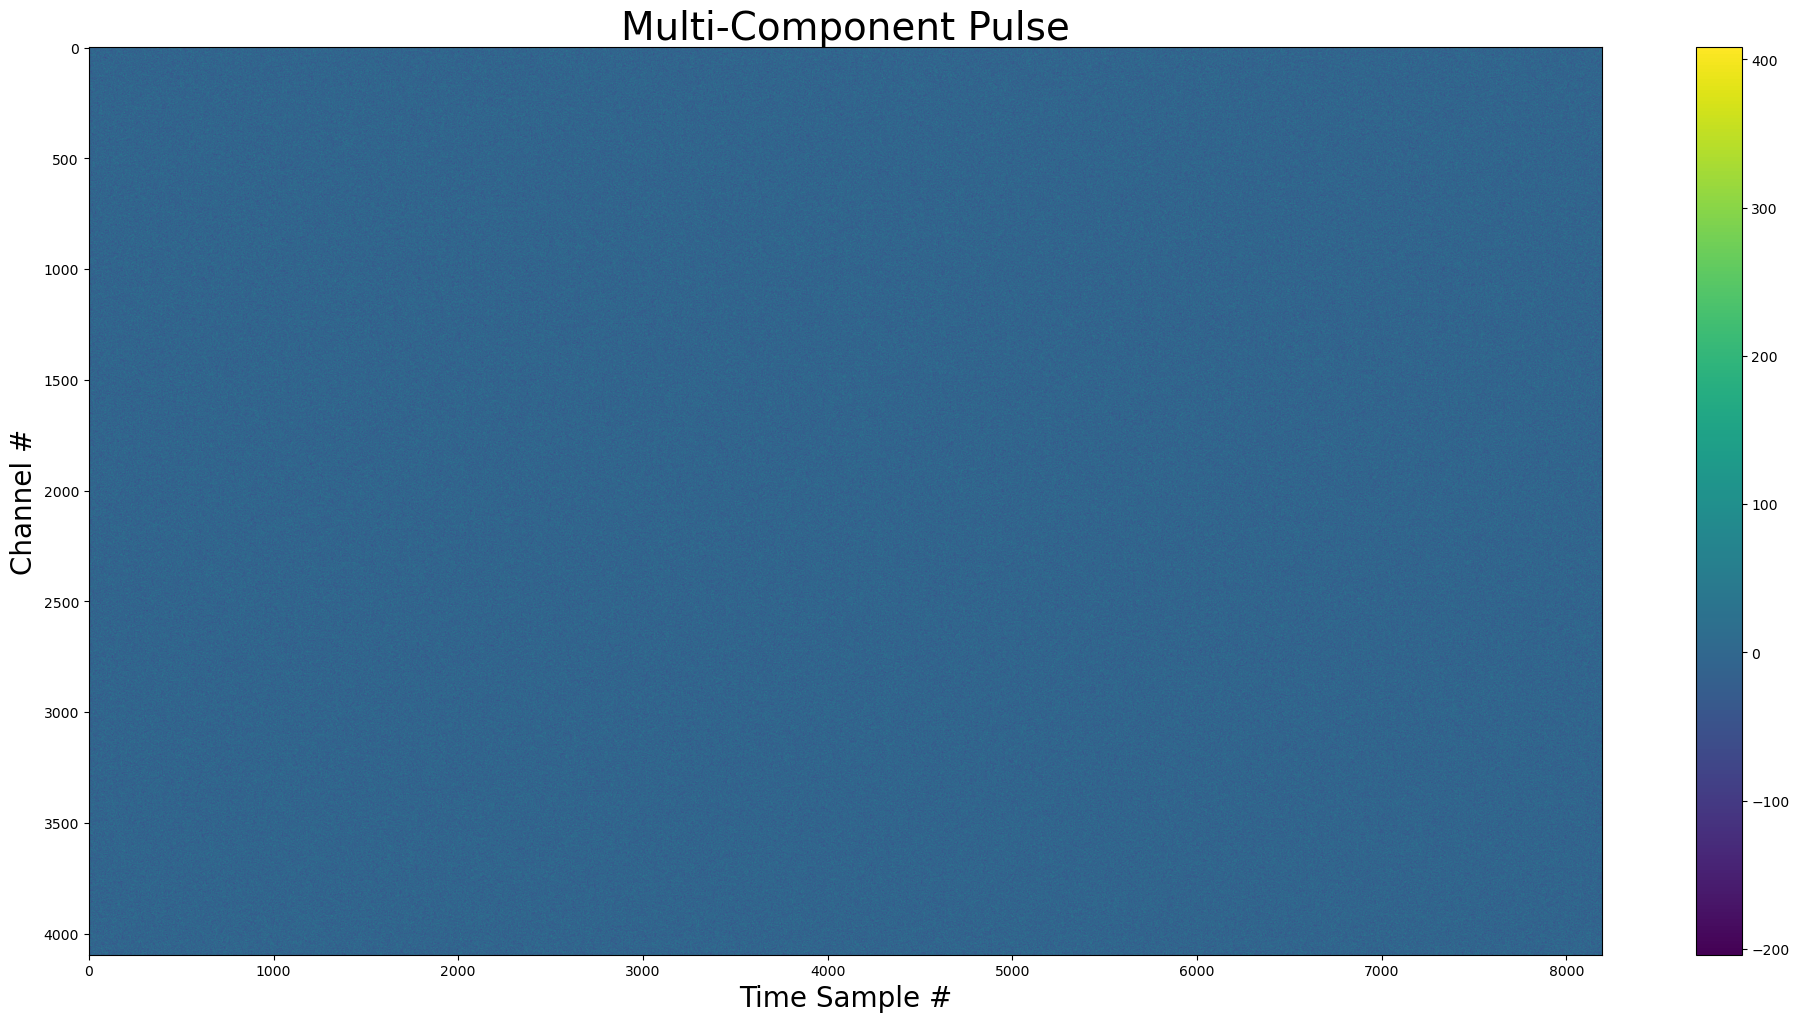

In [ ]:
show_dynamic(
    dedisperse(
        dynamic_spectra_w_pulse_complex,
        dm=dm_1,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    ),
    title="Multi-Component Pulse",
    save=True,
)

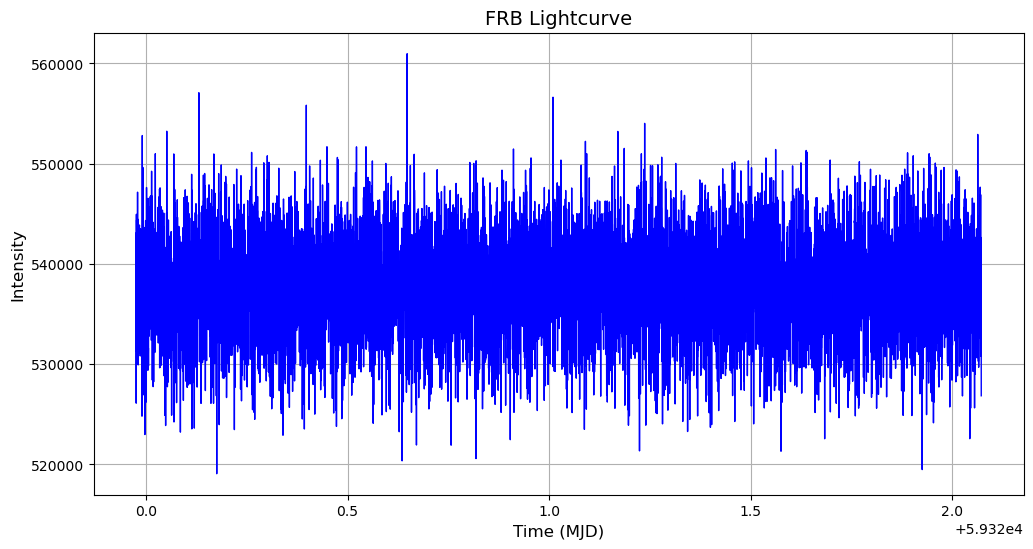

In [ ]:
dedispersed_complex_pulse = dedisperse(
        dynamic_spectra_w_pulse_complex,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )


# Sum the frequencies along the frequency axis to get a 1D time series (lightcurve)
lightcurve = np.sum(dedispersed_complex_pulse, axis=1)

# Extract header information
tsamp = 0.000256
tstart = 59319.97462321287

# Create a time axis for the lightcurve
num_time_samples = len(lightcurve)
time_axis = np.arange(num_time_samples) * tsamp + tstart

# Plot the lightcurve
plt.figure(figsize=(12, 6))
plt.plot(time_axis, lightcurve, color='blue', lw=1)
plt.xlabel("Time (MJD)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title("FRB Lightcurve", fontsize=14)
plt.grid(True)
plt.show()

## Generate simple frbs

Injecting Pulses ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

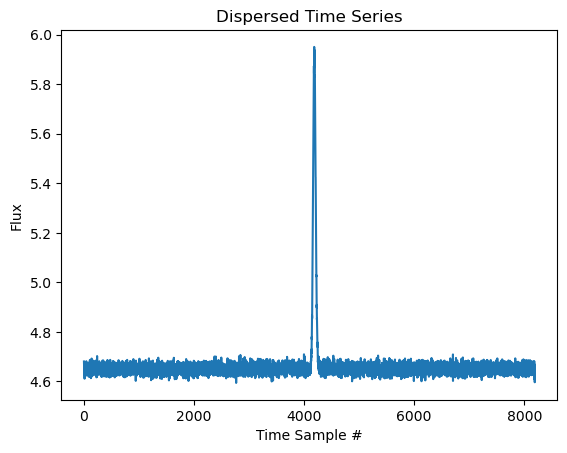

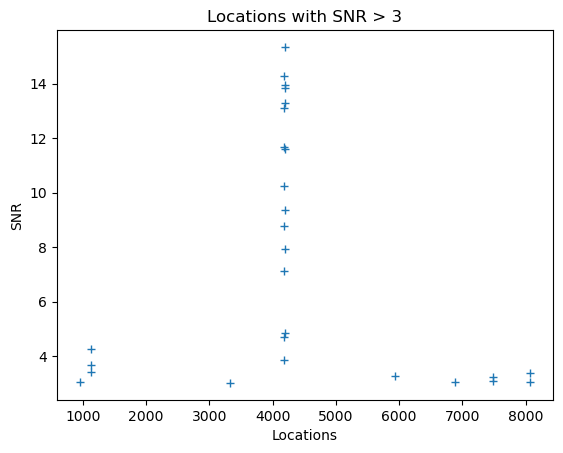

[array([8.093877]), array([20.90310577]), array([11.42379036]), array([19.53589682]), array([8.32874397]), array([24.52469038]), array([10.00189305]), array([10.34825265]), array([21.8935727]), array([48.56326201]), array([4.24746248]), array([48.87039574]), array([98.85490401]), array([44.06465627]), array([31.00222257]), array([22.84758073]), array([17.19645039]), array([25.33893926]), array([8.16071833]), array([54.68786984]), array([11.53316708]), array([28.38325787]), array([144.73827372]), array([4.24746248]), array([187.9598178]), array([61.42674511]), array([38.65859271]), array([21.18870053]), array([21.85467235]), array([25.825058]), array([21.23123592]), array([4.24746248]), array([11.0227424]), array([76.86172037]), array([59.19249781]), array([49.13445153]), array([12.26842167]), array([17.38015553]), array([35.29026729]), array([4.24746248]), array([30.95426175]), array([37.1577011]), array([82.24559391]), array([21.86926677]), array([38.74702726]), array([29.25219511]), 

ValueError: The 'color' keyword argument must have one color per dataset, but 100 datasets and 1 colors were provided

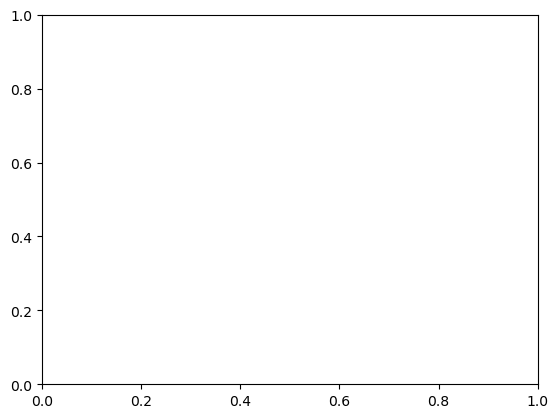

In [ ]:
import os

# Directory to save the numpy arrays
save_dir = "simulated_simple_frbs"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

snrs = []

# Set the constant DM value
dm = 200

# Define the mean values for the Gaussian distributions
mean_value_for_sigma_time = 0.005  # Mean value for pulse width
mean_value_for_sigma_freq = 350    # Mean value for frequency width

# Standard deviations for the Gaussian distributions (adjust as needed)
std_deviation_for_sigma_time = 0.001
std_deviation_for_sigma_freq = 50

# Generate 10 different dynamic spectra with varying signal and temporal widths
num_pulses = 100

for i in range(num_pulses):
    # Draw random values for signal width and temporal width from Gaussian distributions
    sigma_time = np.random.normal(mean_value_for_sigma_time, std_deviation_for_sigma_time)
    sigma_freq = np.random.normal(mean_value_for_sigma_freq, std_deviation_for_sigma_freq)
    
    # Create the pulse object with the specified parameters
    pulse_obj = create.SimpleGaussPulse(
        sigma_time=sigma_time,
        sigma_freq=sigma_freq,
        center_freq=yr_obj.your_header.center_freq,
        dm=dm,  
        tau=20,
        phi=np.pi / 3,
        spectral_index_alpha=0,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
        nscint=0,
        bandpass=None,
    )
    
    # Scale the SNR of the pulse according to powerlaw with slope -1.5 so more weak pulses
    min_value = .75
    max_value = 5

    # Define the exponent for the power law distribution
    exponent = -1.5  # Use a negative exponent

    # Generate a random number from a power law-like distribution
    scaling_factor = ((max_value**(exponent+1) - min_value**(exponent+1)) * np.random.random(1) + min_value**(exponent+1))**(1/(exponent+1))

    # Generate the pulse signal with the specified parameters
    pulse = pulse_obj.sample_pulse(nsamp=int(3e5))

    pulse = pulse * int(scaling_factor)
    
    # Inject the pulse into the dynamic spectra
    dynamic_spectra_w_pulse = inject.inject_constant_into_file(
        yr_input=yr_obj,
        pulse=pulse,
        start=yr_obj.your_header.nspectra // 2,
        gulp=yr_obj.your_header.nspectra,
    )

    dynamic_spectra_w_pulse_dedisp = dedisperse(
        dynamic_spectra_w_pulse,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )

    time_series = detect.dedisped_time_series(
        dynamic_spectra_w_pulse,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )

    plt.title("Dispersed Time Series")
    plt.xlabel("Time Sample #")
    plt.ylabel("Flux")
    plt.plot(time_series)
    plt.show()

    sigma = 3
    pulses = detect.detect_all_pulses(time_series, box_car_length=8, sigma=sigma)
    snrs.append(max(pulses.snrs))

    plt.title(f"Locations with SNR > {sigma}")
    plt.plot(pulses.locations, pulses.snrs, "+")
    plt.ylabel("SNR")
    plt.xlabel("Locations")
    plt.show()
    
    # Define a filename for the numpy array
    filename = os.path.join(save_dir, f"frb_{i}_{sigma_time}_{sigma_freq}.npy")
    
    # Save the dynamic spectra as a numpy array
    np.save(filename, dynamic_spectra_w_pulse_dedisp)

print(snrs)
# After generating SNRs for all pulses, plot the histogram
plt.hist(snrs, bins=20, density=True, alpha=0.7, color='b')
plt.xlabel("SNR")
plt.ylabel("Frequency")
plt.title("SNR Histogram")
plt.show()


## Generate complex frbs

In [ ]:
import os
import numpy as np

# Directory to save the numpy arrays for complex pulses
save_dir_complex = "simulated_complex_frbs"

# Create the directory if it doesn't exist
os.makedirs(save_dir_complex, exist_ok=True)

# Set the constant DM value
dm = 200

# Define the mean values for the Gaussian distributions
mean_value_for_sigma_time = 0.005  # Mean value for pulse width
mean_value_for_sigma_freq = 350    # Mean value for frequency width

# Standard deviations for the Gaussian distributions (adjust as needed)
std_deviation_for_sigma_time = 0.001
std_deviation_for_sigma_freq = 50

# Generate 10 different dynamic spectra with varying signal and temporal widths for complex pulses
num_pulses = 100

for i in range(num_pulses):
    # Draw random values for signal width and temporal width from Gaussian distributions
    sigma_time = np.random.normal(mean_value_for_sigma_time, std_deviation_for_sigma_time)
    sigma_freq = np.random.normal(mean_value_for_sigma_freq, std_deviation_for_sigma_freq)
    
    # Create the pulse object with the specified parameters for complex pulses
    pulse_obj_complex = create.GaussPulse(
        relative_intensities=(1, 0.8, 0.8, 0.8),
        sigma_times=(sigma_time, sigma_time * 0.2, sigma_time * 0.2, sigma_time * 1.2),
        sigma_freqs=(sigma_freq, sigma_freq * 0.8, sigma_freq * 0.8, sigma_freq * 0.6),
        pulse_thetas=(0, 0, 0, -np.pi / 60),
        center_freqs=(yr_obj.your_header.center_freq, yr_obj.your_header.center_freq - 100, yr_obj.your_header.center_freq - 200, yr_obj.your_header.center_freq - 400),
        dm=dm,
        tau=25,
        offsets=(0, 0.01536, 0.02304, 0.03968),  # all from start of window
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
        spectral_index_alpha=0,
        nscint=2,
        phi=0,
        bandpass=None,
    )

    # Scale the SNR of the pulse according to powerlaw with slope -1.5 so more weak pulses
    min_value = .75
    max_value = 5

    # Define the exponent for the power law distribution
    exponent = -1.5  # Use a negative exponent

    # Generate a random number from a power law-like distribution
    scaling_factor = ((max_value**(exponent+1) - min_value**(exponent+1)) * np.random.random(1) + min_value**(exponent+1))**(1/(exponent+1))

    # Generate the complex pulse signal with the specified parameters
    pulse_complex = pulse_obj_complex.sample_pulse(nsamp=int(3e5))

    pulse_complex = pulse_complex * int(scaling_factor)
    
    
    
    # Inject the complex pulse into the dynamic spectra
    dynamic_spectra_w_pulse_complex = inject.inject_constant_into_file(
        yr_input=yr_obj,
        pulse=pulse_complex,
        start=yr_obj.your_header.nspectra // 2,
        gulp=yr_obj.your_header.nspectra,
    )

    dynamic_spectra_w_pulse_complex_dedisp = dedisperse(
        dynamic_spectra_w_pulse_complex,
        dm=dm,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )
    
    # Define a filename for the numpy array for complex pulses
    filename_complex = os.path.join(save_dir_complex, f"complex_frb_{i}_{sigma_time}_{sigma_freq}.npy")
    
    # Save the dynamic spectra with complex pulses as a numpy array
    np.save(filename_complex, dynamic_spectra_w_pulse_complex_dedisp)


Injecting Pulses ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--